In [1]:
import json
import os
import PIL
import PIL.Image
from IPython.display import display
from PIL import Image

import keras
from keras.utils import plot_model
from keras_preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import re
from datetime import datetime as dt


# Import all the Keras machinery we need
from keras import applications
from keras import optimizers
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras import metrics

Using TensorFlow backend.


In [2]:
# Prepare our training / validation / etc set
def getData():
    filename = './pair_only_info.csv'
    pair_only_info = pd.read_csv(filename)
    im1 = []
    im2 = []
    labels = []
    indexes = []
    k=0
    register = ['godet-vide', 'ela', 'pet-opaque', 'pe-hd-opaque', 'pet-fonce', 'pet-clair', 'plusieurs-objets', \
                'pp', 'pet-barquette-opaque', 'pet-barquette-clair', 'iconnnu', 'peld', 'alu','not-labeled']
    
    categories = ['godet-vide', 'pet-fonce', 'pet-clair']

    register_dict = {el:0 for el in register}


    for index, row in pair_only_info.iterrows():

        register_dict[row['label']] = register_dict[row['label']] +1 


        if row['label'] in categories:
            indexes.append(index)
            labels.append(row['label'])
            im1.append(row['cam1'])
            im2.append(row['cam2'])

                
    print(register_dict)
    print(len(im1),len(im2),len(indexes))
    
    return indexes, labels, pair_only_info


def splitData(indexes,y,pair_only_info):
    
    output_dir = './dataset_paired_split'
    indexes_train, indexes_test, y_train, y_test = train_test_split(indexes, y, test_size=0.2, random_state=42, stratify=y)

    #Create folder for the test and training split

        
    
    
    train_pairs = pair_only_info.iloc[indexes_train]
    test_pairs = pair_only_info.iloc[indexes_test]
    
    #Copying files into test and train folder
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
        os.mkdir(output_dir + '/test')
        os.mkdir(output_dir + '/test/cam1')
        os.mkdir(output_dir + '/test/cam2')
        os.mkdir(output_dir + '/train')
        os.mkdir(output_dir + '/train/cam1')
        os.mkdir(output_dir + '/train/cam2')
        
        for index, row in test_pairs.iterrows():
            #file = file.replace(':','_')
            os.system('cp ./dataset_grouped/'+ row['cam2'] + ' ' + output_dir + '/test/cam2/' + row['cam2'])
            os.system('cp ./dataset_grouped/'+ row['cam1'] + ' ' + output_dir + '/test/cam1/' + row['cam1'])

        for index, row in train_pairs.iterrows():
            #file = file.replace(':','_')
            os.system('cp ./dataset_grouped/'+ row['cam2'] + ' ' + output_dir + '/train/cam2/' + row['cam2'])
            os.system('cp ./dataset_grouped/'+ row['cam1'] + ' ' + output_dir + '/train/cam1/' + row['cam1'])


    else:
        print("Warning: output dir {} already exists".format(output_dir))


    return train_pairs, test_pairs




indexes, y, pair_only_info = getData()
train_pairs, test_pairs = splitData(indexes,y, pair_only_info)
#X_train, X_vali, y_train, y_vali = splitValidation(X_try, y_try)
#print(X[2])

{'godet-vide': 116, 'ela': 9, 'pet-opaque': 15, 'pe-hd-opaque': 249, 'pet-fonce': 289, 'pet-clair': 270, 'plusieurs-objets': 28, 'pp': 150, 'pet-barquette-opaque': 6, 'pet-barquette-clair': 34, 'iconnnu': 15, 'peld': 5, 'alu': 0, 'not-labeled': 42}
675 675 675


In [3]:
x = train_pairs['label'].tolist()
print(x[1])
X1 = train_pairs[['cam1','label']]
print(type(X1))

pet-clair
<class 'pandas.core.frame.DataFrame'>


In [4]:
n_train_samples = len(train_pairs) * 0.8
n_val_samples = len(train_pairs) * 0.2
batch_size = 16
img_height = 224
img_width = 224

target_labels = train_pairs['label'].tolist()

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

X1 = train_pairs[['cam1','label']]
X1.index = range(len(X1))
X1.columns = ['id','label']

X2 = train_pairs[['cam2','label']]
X2.index = range(len(X2))
X2.columns = ['id','label']

print(X1)

input_imgen = ImageDataGenerator(preprocessing_function=preprocess_input,
    validation_split=0.2)



def generate_generator_multiple(generator,X1, X2, batch_size, img_height,img_width,target_labels, split_name):
    
    genX1 = generator.flow_from_dataframe(X1,
                                          directory = './dataset_paired_split/train/cam1',
                                          target_size = (img_height,img_width),
                                          class_mode = 'categorical',
                                          subset= split_name,
                                          x_col='id',
                                          y_col='label',
                                          batch_size = batch_size,
                                          classes = target_labels, 
                                          shuffle=False, 
                                          seed=7)
    
    genX2 = generator.flow_from_dataframe(X2,
                                          directory = './dataset_paired_split/train/cam2',
                                          target_size = (img_height,img_width),
                                          class_mode = 'categorical',
                                          subset=split_name,
                                          x_col='id',
                                          y_col='label',
                                          batch_size = batch_size,
                                          classes = target_labels, 
                                          shuffle=False, 
                                          seed=7)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            #print([X1i[0], X2i[0]], X2i[1])
            yield [X1i[0], X2i[0]], X2i[1]  #Yield both images and their mutual label
            

            
train_generator=generate_generator_multiple(input_imgen,
                                           X1,
                                           X2,
                                           batch_size,
                                           img_height,
                                           img_width,
                                           target_labels,
                                           "training")       
     
validation_generator=generate_generator_multiple(input_imgen,
                                           X1,
                                           X2,
                                           batch_size,
                                           img_height,
                                           img_width,
                                           target_labels,
                                           "validation")               


                                                    id       label
0    2019-04-12-09-27-05-613889-CAM1_pet-fonce_grp9...   pet-fonce
1    2019-04-05-11-54-29-509887-CAM1_pet-clair_grp3...   pet-clair
2    2019-04-13-12-45-17-477572-CAM1_pet-fonce_grp1...   pet-fonce
3    2019-04-05-12-19-22-384317-CAM1_godet-vide_grp...  godet-vide
4    2019-04-13-12-07-30-244268-CAM1_pet-clair_grp1...   pet-clair
5    2019-04-05-12-35-35-989523-CAM1_pet-fonce_grp6...   pet-fonce
6    2019-04-12-18-07-31-882978-CAM1_godet-vide_grp...  godet-vide
7    2019-04-13-12-09-23-912436-CAM1_pet-clair_grp1...   pet-clair
8    2019-04-05-13-53-31-374019-CAM1_pet-fonce_grp6...   pet-fonce
9    2019-04-11-20-15-00-351175-CAM1_pet-fonce_grp8...   pet-fonce
10   2019-04-05-14-02-39-000967-CAM1_pet-clair_grp7...   pet-clair
11   2019-04-12-15-11-38-139483-CAM1_pet-clair_grp9...   pet-clair
12   2019-04-05-12-38-46-064383-CAM1_pet-clair_grp6...   pet-clair
13   2019-04-05-09-52-17-973687-CAM1_godet-vide_grp...  godet-

In [5]:
# Build a two CNN merging into one output
# Like in https://github.com/keras-team/keras/issues/3386

from keras.models import Sequential, Input
from keras.layers import Conv2D, MaxPooling2D, concatenate
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization


if K.image_data_format() == 'channels_first':
    input_shape = (3, 224, 224)
else:
    input_shape = (224, 224, 3)
    
# CREATING MODEL 1
input1 = Input(shape = input_shape)
tower1 = Conv2D(32, (3, 3), padding = 'same',activation = 'relu')(input1)
tower1 = BatchNormalization()(tower1)
tower1 = MaxPooling2D(pool_size=(2, 2))(tower1)


tower1 = Conv2D(32, (3, 3), padding = 'same',activation = 'relu')(tower1)
tower1 = BatchNormalization()(tower1)
tower1 = MaxPooling2D(pool_size=(2, 2))(tower1)

tower1 = Conv2D(32, (3, 3), padding = 'same',activation = 'relu')(tower1)
tower1 = BatchNormalization()(tower1)
tower1 = MaxPooling2D(pool_size=(2, 2))(tower1)

tower1 = Flatten()(tower1)

tower1 = Model(inputs=input1, outputs = tower1)
                  
# CREATING MODEL 2
input2 = Input(shape = input_shape)
tower2 = Conv2D(32, (3, 3), padding = 'same',activation = 'relu')(input2)
tower2 = BatchNormalization()(tower2)
tower2 = MaxPooling2D(pool_size=(2, 2))(tower2)


tower2 = Conv2D(32, (3, 3), padding = 'same',activation = 'relu')(tower2)
tower2 = BatchNormalization()(tower2)
tower2 = MaxPooling2D(pool_size=(2, 2))(tower2)


tower2 = Conv2D(32, (3, 3), padding = 'same',activation = 'relu')(tower2)
tower2 = BatchNormalization()(tower2)
tower2 = MaxPooling2D(pool_size=(2, 2))(tower2)

tower2 = Flatten()(tower2)                  

tower2 = Model(inputs=input2, outputs = tower2)


#Combine them

combined = concatenate([tower1.output, tower2.output])


# Apply final FC layers

z = Dense(64, activation = 'relu')(combined)
z = Dense(64, activation = 'relu')(z)
z = Dense(32, activation = 'relu')(z)
z = Dense(3, activation = 'softmax')(z)

model = Model(inputs = [tower1.input, tower2.input], outputs = z)




model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

#optimizer=optimizers.Adam(lr=3e-6),

plot_model(model, to_file='full_model.png', show_shapes = True)
plot_model(tower1, to_file='tower1.png', show_shapes = True)
plot_model(tower2, to_file='tower2.png', show_shapes = True)

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
'''
# Build a two CNN merging into one output
# Like in https://github.com/keras-team/keras/issues/3386

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Concatenate
from keras.layers import Activation, Dropout, Flatten, Dense


if K.image_data_format() == 'channels_first':
    input_shape = (3, 224, 224)
else:
    input_shape = (224, 224, 3)
    
# CREATING MODEL 1
img_model1 = Sequential()
img_model1.add(Conv2D(32, (3, 3), input_shape=input_shape))
img_model1.add(Activation('relu'))
img_model1.add(MaxPooling2D(pool_size=(2, 2)))

img_model1.add(Conv2D(32, (3, 3)))
img_model1.add(Activation('relu'))
img_model1.add(MaxPooling2D(pool_size=(2, 2)))

img_model1.add(Conv2D(64, (3, 3)))
img_model1.add(Activation('relu'))
img_model1.add(MaxPooling2D(pool_size=(2, 2)))

img_model1.add(Conv2D(64, (3, 3)))
img_model1.add(Activation('relu'))
img_model1.add(MaxPooling2D(pool_size=(2, 2)))

img_model1.add(Flatten())
img_model1.add(Dense(64))
img_model1.add(Activation('relu'))

img_model1.add(Dropout(0.5))



# CREATING MODEL 2
img_model2 = Sequential()
img_model2.add(Conv2D(32, (3, 3), input_shape=input_shape))
img_model2.add(Activation('relu'))
img_model2.add(MaxPooling2D(pool_size=(2, 2)))

img_model2.add(Conv2D(32, (3, 3)))
img_model2.add(Activation('relu'))
img_model2.add(MaxPooling2D(pool_size=(2, 2)))

img_model2.add(Conv2D(64, (3, 3)))
img_model2.add(Activation('relu'))
img_model2.add(MaxPooling2D(pool_size=(2, 2)))

img_model2.add(Conv2D(64, (3, 3)))
img_model2.add(Activation('relu'))
img_model2.add(MaxPooling2D(pool_size=(2, 2)))

img_model2.add(Flatten())
img_model2.add(Dense(64))
img_model2.add(Activation('relu'))

img_model2.add(Dropout(0.5))


#MERGING THEM

model = Sequential()
model.add(Concatenate([img_model1, img_model2]))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

#optimizer=optimizers.Adam(lr=3e-6),


plot_model(model, to_file='model.png', show_shapes = True)
plot_model(img_model1, to_file='img_model1.png', show_shapes = True)
plot_model(img_model2, to_file='img_model2.png', show_shapes = True)

'''

In [6]:
history=model.fit_generator(train_generator,
                        steps_per_epoch=n_train_samples // batch_size,
                        epochs = 100,
                        validation_data = validation_generator,
                        validation_steps = n_val_samples // batch_size,
                        shuffle=False)



Instructions for updating:
Use tf.cast instead.
Epoch 1/100
Found 432 images belonging to 3 classes.Found 108 images belonging to 3 classes.

Found 108 images belonging to 3 classes.
Found 432 images belonging to 3 classes.
27/27 [==============================] - 79s 3s/step - loss: 7.0205 - acc: 0.4398 - val_loss: 10.7794 - val_acc: 0.2812
Epoch 2/100
27/27 [==============================] - 79s 3s/step - loss: 2.3347 - acc: 0.5347 - val_loss: 1.7523 - val_acc: 0.5326
Epoch 3/100
27/27 [==============================] - 79s 3s/step - loss: 0.9102 - acc: 0.6759 - val_loss: 1.1969 - val_acc: 0.5978
Epoch 4/100
27/27 [==============================] - 78s 3s/step - loss: 0.6550 - acc: 0.7546 - val_loss: 0.8648 - val_acc: 0.6848
Epoch 5/100
27/27 [==============================] - 78s 3s/step - loss: 0.6951 - acc: 0.7685 - val_loss: 0.9316 - val_acc: 0.6196
Epoch 6/100
27/27 [==============================] - 78s 3s/step - loss: 0.4589 - acc: 0.8264 - val_loss: 0.7041 - val_acc: 0.7283
E

KeyboardInterrupt: 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
0.7808219178082192


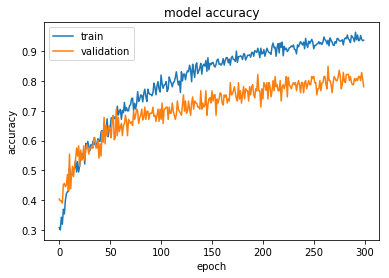

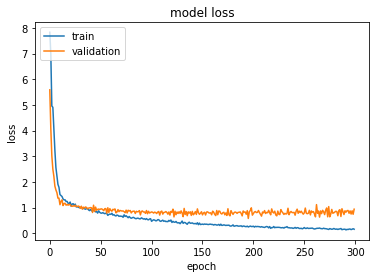

In [10]:
cnnmodel.save('cnn_v1_4lb.h5')
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
print(history.history['val_acc'][-1])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [10]:
# Avec K-Fold CROSS VALIDATION ( a faire)
'''
for j, (train_idx, val_idx) in enumerate(folds):
    
    print('\nFold ',j)
    X_train_cv = X_train[train_idx]
    y_train_cv = y_train[train_idx]
    X_valid_cv = X_train[val_idx]
    y_valid_cv= y_train[val_idx]
    
    name_weights = "final_model_fold" + str(j) + "_weights.h5"
    callbacks = get_callbacks(name_weights = name_weights, patience_lr=10)
    generator = gen.flow(X_train_cv, y_train_cv, batch_size = batch_size)
    model = get_model()
    model.fit_generator(
                generator,
                steps_per_epoch=len(X_train_cv)/batch_size,
                epochs=15,
                shuffle=True,
                verbose=1,
                validation_data = (X_valid_cv, y_valid_cv),
                callbacks = callbacks)
    
    model.fit_generator(
                train_generator,
                steps_per_epoch=n_train_samples // batch_size,
                epochs=6,
                validation_data=validation_generator,
                validation_steps=n_val_samples // batch_size,
)
    
    print(model.evaluate(X_valid_cv, y_valid_cv))
# Leeeet's traaaaaaaaiiiiin!!!!
'''

'\nfor j, (train_idx, val_idx) in enumerate(folds):\n    \n    print(\'\nFold \',j)\n    X_train_cv = X_train[train_idx]\n    y_train_cv = y_train[train_idx]\n    X_valid_cv = X_train[val_idx]\n    y_valid_cv= y_train[val_idx]\n    \n    name_weights = "final_model_fold" + str(j) + "_weights.h5"\n    callbacks = get_callbacks(name_weights = name_weights, patience_lr=10)\n    generator = gen.flow(X_train_cv, y_train_cv, batch_size = batch_size)\n    model = get_model()\n    model.fit_generator(\n                generator,\n                steps_per_epoch=len(X_train_cv)/batch_size,\n                epochs=15,\n                shuffle=True,\n                verbose=1,\n                validation_data = (X_valid_cv, y_valid_cv),\n                callbacks = callbacks)\n    \n    model.fit_generator(\n                train_generator,\n                steps_per_epoch=n_train_samples // batch_size,\n                epochs=6,\n                validation_data=validation_generator,\n           

In [12]:

#Y_pred = cnnmodel.predict_generator(validation_generator, n_val_samples // batch_size+1)
#y_pred = np.argmax(Y_pred, axis=1)
#validation_generator.classes
#y_pred
n_correct = 0
#import pdb;pdb.set_trace()
for _val_xs, _val_ys in validation_generator:#n_validation_samples // batch_size):
    for idx in range(len(_val_ys)):
        img = _val_xs[idx]
        _y = np.argmax(_val_ys[idx], axis=0)
        pred = np.argmax(model.predict(np.expand_dims(img, axis=0)), axis=1)
        print(_y, pred, pred == _y)
#        n_correct += pred == _y and 1 or 0
#print("Correct answers = %0.2f%%" % (n_correct / len(validation_generator.classes) * 100))

1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
2 [1] [False]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [2] [False]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [1] [False]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [2] [False]
0 [0] [ True]
1 [1] [ True]
1 [1] 

1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [1] [False]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [1] [False]
2 [2] [ True]
0 [0] [ True]
1 [2] [False]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [1] [False]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
1 [2] [False]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [1] [False]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] 

1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [2] [False]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [2] [False]
0 [2] [False]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [2] [False]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [2] [False]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [1] [False]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] 

2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [2] [False]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
2 [1] [False]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
2 [1] [False]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [1] [False]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [2] [False]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [2] [False]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [2] [False]
0 [0] [ True]
0 [0] 

0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [2] [False]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
0 [2] [False]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
0 [2] [False]
0 [0] [ True]
1 [2] [False]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [1] [False]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] 

2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [2] [False]
0 [2] [False]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
2 [1] [False]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [1] [False]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [2] [False]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] 

0 [1] [False]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [1] [False]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [2] [False]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
1 [2] [False]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [2] [False]
1 [1] [ True]
0 [2] [False]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] 

1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [1] [False]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [2] [False]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [2] [False]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [2] [False]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [1] [False]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [2] [False]
1 [1] [ True]
1 [1] [ True]
1 [1] 

2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [1] [False]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [2] [False]
1 [1] [ True]
1 [1] [ True]
2 [1] [False]
2 [2] [ True]
0 [0] [ True]
2 [1] [False]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [2] [False]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
2 [1] [False]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [2] [False]
1 [1] 

0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
2 [1] [False]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [2] [False]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [1] [False]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] 

2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [2] [False]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [2] [False]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [1] [False]
0 [0] [ True]
1 [1] 

1 [1] [ True]
1 [1] [ True]
1 [2] [False]
0 [2] [False]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [2] [False]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [2] [False]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [1] [False]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [1] [False]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [1] [False]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] 

0 [0] [ True]
2 [1] [False]
0 [2] [False]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [2] [False]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [1] [False]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [1] [False]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [2] [False]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] 

0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [2] [False]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [2] [False]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] 

1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [2] [False]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [2] [False]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [2] [False]
1 [1] [ True]
0 [2] [False]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [2] [False]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] 

1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
0 [2] [False]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [2] [False]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [2] [False]
0 [2] [False]
0 [2] [False]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [1] [False]
1 [1] 

0 [2] [False]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [2] [False]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
0 [2] [False]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [1] [False]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
2 [1] [False]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [1] [False]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] 

1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [1] [False]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [2] [False]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [2] [False]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [2] [False]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
0 [2] [False]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
2 [1] [False]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [2] [False]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] 

1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [1] [False]
0 [2] [False]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [2] [False]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] 

2 [1] [False]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [2] [False]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
1 [2] [False]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [2] [False]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
0 [1] [False]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [2] [False]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] 

1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
0 [1] [False]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [2] [False]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [1] [False]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [1] [False]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [2] [False]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [2] [False]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] 

0 [1] [False]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [2] [False]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [1] [False]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [2] [False]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [2] [False]
1 [1] [ True]
0 [0] 

2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [2] [False]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [1] [False]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [2] [False]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [2] [False]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [1] [False]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [1] [False]
0 [2] [False]
1 [1] [ True]
1 [2] [False]
1 [1] [ True]
2 [2] 

1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [2] [False]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [1] [False]
2 [1] [False]
0 [0] [ True]
1 [2] [False]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [2] [False]
2 [2] [ True]
2 [2] [ True]
0 [2] [False]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [2] [False]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] 

1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [1] [False]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [1] [False]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [2] [False]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
0 [2] [False]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [1] [False]
0 [0] [ True]
1 [1] 

2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [2] [False]
2 [2] [ True]
1 [2] [False]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [2] [False]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [2] [False]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [1] [False]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [2] [False]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] 

2 [2] [ True]
1 [1] [ True]
1 [2] [False]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [2] [False]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [2] [False]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] 

1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
0 [2] [False]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [2] [False]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] 

2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [1] [False]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [1] [False]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [1] [False]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [1] [False]
0 [2] [False]
0 [0] [ True]
2 [2] [ True]
0 [0] 

2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [2] [False]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [1] [False]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] 

2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [2] [False]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [2] [False]
2 [2] [ True]
0 [0] [ True]
2 [1] [False]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [1] [False]
2 [1] [False]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [2] [False]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
2 [1] 

2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [2] [False]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
2 [1] [False]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] 

1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
0 [2] [False]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [1] [False]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [2] [False]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [2] 

1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [2] [False]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [1] [False]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
2 [1] [False]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] 

KeyboardInterrupt: 

In [11]:
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


def evaluate(X_test, y_test):
    TEST_DIR =  "./dataset_split/test"
    HEIGHT = 224
    WIDTH = 224
    BATCH_SIZE = 16

    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    
    test_info = {'id':X_test,'label':y_test}

    testdf = pd.DataFrame(test_info)


    test_generator=test_datagen.flow_from_dataframe(
        dataframe=testdf,
        directory="./dataset_split/test/",
        x_col="id",
        y_col="label",
        batch_size=BATCH_SIZE,
        shuffle=False,
        class_mode="categorical",
        target_size=(HEIGHT,WIDTH))
        
        
    model = load_model('cnn_v1.h5')

    
    probabilities = model.predict_generator(test_generator, len(test_generator))


    #y_pred = np.rint(probabilities)
    y_true = test_generator.classes

    y_pred = probabilities.argmax(axis=-1)

    print(confusion_matrix(y_true, y_pred))

    acc = accuracy_score(y_true, y_pred)
    catego = ["godet-vide","pe-hd-opaque","pet-clair","pet-fonce"]
    for i in range(145):
        if y_pred[i] != y_true[i]:
            
            print('Le fichier {} , of class {}, has been classified as {}'.format(X_test[i],catego[y_true[i]],catego[y_pred[i]]))
            #plt.imshow('./dataset_split/test/X_test[i]')
            #plt.show
    print(acc)

    
evaluate(X_test, y_test)

#print(y_test)


Found 203 images belonging to 4 classes.
[[27  0  0  0]
 [ 1 51  2  3]
 [ 1  7 44  7]
 [ 0  2  2 56]]
Le fichier wsEN4iv2SliFUuYNXIM-5Q:GWUZrOjPR426QPzMSdv0cg:320x200.png , of class pe-hd-opaque, has been classified as pet-clair
Le fichier wsEN4iv2SliFUuYNXIM-5Q:VEydN4T9Qz6KQ4mMc4qYVA:320x200.png , of class pet-clair, has been classified as pet-fonce
Le fichier wsEN4iv2SliFUuYNXIM-5Q:j2qZfv5qSnamD8s48kuzug:320x200.png , of class pet-clair, has been classified as pet-fonce
Le fichier wsEN4iv2SliFUuYNXIM-5Q:2FpN9g93S-Krb195HJCwbw:320x200.png , of class pet-clair, has been classified as pe-hd-opaque
Le fichier wsEN4iv2SliFUuYNXIM-5Q:XdniCIazSXCAmQoGuAIlrg:320x200.png , of class pet-clair, has been classified as pe-hd-opaque
Le fichier wsEN4iv2SliFUuYNXIM-5Q:geuYeKUaTCmixshV29m_jA:320x200.png , of class pet-fonce, has been classified as pe-hd-opaque
Le fichier wsEN4iv2SliFUuYNXIM-5Q:nrNfaiUrQt6gTL4t2LIm1Q:320x200.png , of class pe-hd-opaque, has been classified as godet-vide
Le fichier wsE

In [23]:
'''

#from keras.models import load_model
#from sklearn.metrics import confusion_matrix
#import matplotlib
#import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          ):
    """
    This function prints and plots the confusion matrix.
    """
    
    cmap = plt.cm.jet
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:.2f}'.format(cm[i, j]), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
cnnmodel = load_model('vgg16_v3.h5')
#Confusion Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = cnnmodel.predict_generator(validation_generator, n_val_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred, target_names=target_labels))

# Sample prediction
for idx in range(10):
    img = image.load_img(X[idx], target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    pred = cnnmodel.predict(x)
    print(X[idx], list(target_labels).index(y[idx]), np.argmax(pred), pred)
    
# Plot a pretty confusion matrix
np.set_printoptions(precision=2)
dev_feats = read_dataset('valid')
predictions = emotion_classifier.predict_classes(dev_feats)
te_labels = get_labels('valid')
conf_mat = confusion_matrix(validation_generator.classes, y_pred)


plt.figure()
plot_confusion_matrix(conf_mat, classes=target_labels)
plt.show()
'''

NameError: name 'CATEGORIES' is not defined

In [11]:
from keras.models import load_model
import numpy as np
from keras.preprocessing import image
import time





def classify(im_name):
    
    #model = load_model('model_gl_pl.h5')

    HEIGHT = 224
    WIDTH = 224


    # If you wish to test images, please put them in the same folder as the programm
    
    # Image preparation 
    img = image.load_img(im_name, target_size=(HEIGHT, WIDTH)) #resize
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)# correct shape for classification
    im_ready = np.vstack([x])

    classe = model.predict(im_ready)
    classe =classe.argmax(axis = -1) #taking index of the maximum %
    return classe[0]






model = load_model('vgg16_v3.h5')
t_start = time.time()
print(classify('./dataset/wsEN4iv2SliFUuYNXIM-5Q_0AGdsJ3jTp-mb1Ew1tF-gg_320x200.png'))
t_end = time.time()
print(t_end-t_start)

2
0.30704712867736816
